In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import wandb
from scipy.special import expit

https://wandb.ai/smaia3/Ques3/reports/Question-3--Vmlldzo1NzU1MzU3?accessToken=3kf0tpwd55tzmmcrm0h8hd4k199c3t64d2256e4kfvs7wspyqxxr7df1ovvjhshj

In [15]:
class MLPRegressor:
    def __init__(self, input_size, hidden_layers, learning_rate, activation):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = 1
        self.learning_rate = learning_rate
        # Random initialization
        self.neurons_layer = [input_size] + hidden_layers + [1]
        std_deviation = np.sqrt(2.0 / input_size)
        self.weights = [np.random.randn(self.neurons_layer[i], self.neurons_layer[i + 1])*std_deviation for i in range(len(self.neurons_layer) - 1)]
        self.biases = [np.zeros((1, neurons)) for neurons in self.neurons_layer[1:]]
        self.activation = activation
        self.istrain = 0

    def sigmoid(self, x):
        if(self.activation == 'sigmoid'):
            return 1 / (1 + np.exp(-x))
        elif(self.activation == 'tanh'):
            exp_x = np.exp(2 * x)
            tanh_x = (exp_x - 1) / (exp_x + 1)
            return tanh_x
        elif(self.activation == 'relu'):
            if self.istrain:                         # to prevent overflow we use leaky relu
                return np.maximum(0, 0.01*x)
            return np.maximum(0, x)

    def sigmoid_derivative(self, x):
        if(self.activation == 'sigmoid'):
            return x * (1 - x)
        elif(self.activation == 'tanh'):
            return 1 - x**2
        elif(self.activation == 'relu'):
            return (x > 0)


    def mean_squared_error(self, predicted, actual):
        return np.mean((predicted - actual)**2)

    def forward_propagation(self, x):
        self.layer_outputs = [x]
        for i in range(len(self.neurons_layer) - 1):
            z = np.dot(self.layer_outputs[i], self.weights[i]) + self.biases[i]
            a = self.sigmoid(z) if i != len(self.neurons_layer) - 2 else z
            self.layer_outputs.append(a)
        
        return self.layer_outputs[-1]

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            x = x.reshape(1, -1)
            predicted = self.forward_propagation(x)
            predictions.append(predicted)
        return np.vstack(predictions)

    def backward_propagation(self, X, y):
        gradients = []
        deltas = [2 * (self.layer_outputs[-1] - y)] #/ X.shape[0]]
        for i in range(len(self.neurons_layer) - 2, 0, -1):
            delta = np.dot(deltas[-1], self.weights[i].T) * self.sigmoid_derivative(self.layer_outputs[i])
            deltas.append(delta)
        deltas.reverse()
        num_samples = X.shape[0]
        for i in range(len(self.hidden_layers), -1, -1):
            grad_weights = np.dot(self.layer_outputs[i].T, deltas[i]) / num_samples
            grad_biases = np.sum(deltas[i], axis=0, keepdims=True) / num_samples
            gradients.append((grad_weights, grad_biases))
        return gradients

    def update(self, gradients):
        gradients.reverse()
        for i in range(len(self.hidden_layers) + 1):
            grad_weights, grad_biases = gradients[i]
            self.weights[i] -= self.learning_rate * grad_weights
            self.biases[i] -= self.learning_rate * grad_biases

    def train(self, X_train, y_train, num_epochs):
        ep = num_epochs//10
        self.istrain = 1
        for epoch in range(ep):
            for x, y in zip(X_train, y_train):
                x = x.reshape(1, -1)
                y = y.reshape(1, -1)
                self.forward_propagation(x)
                gradients = self.backward_propagation(x, y)
                self.update(gradients)
            self.eval(epoch)
        self.istrain = 0

    def trainbatch(self, x, y, num_epochs):
        for epoch in range(num_epochs):
            gradients = []
            self.forward_propagation(x)
            gradients += self.backward_propagation(x, y)
            gradients = [(np.mean(grad[0], axis=0), np.mean(grad[1], axis=0)) for grad in gradients]
            self.update(gradients)
            if epoch % 10 == 0:
                self.eval(epoch)

    def trainminibatch(self, x, y, num_epochs):
        for epoch in range(num_epochs):
            gradients = []
            batch_size = 50
            num_batches = x.shape[0] // batch_size
            for i in range(num_batches):
                x_batch = x[i * batch_size: (i + 1) * batch_size]
                y_batch = y[i * batch_size: (i + 1) * batch_size]
                self.forward_propagation(x_batch)
                gradients += self.backward_propagation(x_batch, y_batch)
                gradients = [(np.mean(grad[0], axis=0), np.mean(grad[1], axis=0)) for grad in gradients]
                self.update(gradients)
                gradients = []
            if epoch % 10 == 0:
                self.eval(epoch)


    def eval(self, epoch):
        return
        y_pred = self.predict(X_val)
        # if y_pred has nan values return 0
        if np.isnan(y_pred).any():
            return 0
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        rmse = np.sqrt(mse)
        if istrain:
            epoch = epoch * 10
        wandb.log({'epoch': epoch, 'mse': mse, 'r2': r2, 'rmse': rmse})

In [ ]:
# Hyperparameters for WANDB

# Load the data
data = pd.read_csv('HousingData.csv')

# Handle missing values by filling with means
data.fillna(data.mean(), inplace=True)

# Split the data into features (X) and the target (y)
X = data.drop(columns=['MEDV'])
y = data['MEDV']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# iterate over various learning rates, activation functions, and hidden layers and log on WandB

learning_rates = [0.01, 0.001, 0.0001]
activations = ['tanh', 'relu', 'sigmoid']
hidden_layers = [[10], [10, 15], [10, 15, 10]]
for activation in activations:
    for lr in learning_rates:
        for hidden_layer in hidden_layers:
            wandb.init(project="Ques3", config={"learning_rate": lr, "activation": activation, "hidden_layer": hidden_layer, "Optimizer": "SGD"})
            config = wandb.config
            mlp = MLPRegressor(X_train.shape[1], config.hidden_layer, config.learning_rate, config.activation)
            mlp.train(X_train, y_train.values.reshape(-1, 1), 10000)

for lr in learning_rates:
    for activation in activations:
        for hidden_layer in hidden_layers:
            wandb.init(project="Ques3", config={"learning_rate": lr, "activation": activation, "hidden_layer": hidden_layer, "Optimizer": "Batch"})
            config = wandb.config
            mlp = MLPRegressor(X_train.shape[1], config.hidden_layer, config.learning_rate, config.activation)
            mlp.trainbatch(X_train, y_train.values.reshape(-1, 1), 10000)


for lr in learning_rates:
    for activation in activations:
        for hidden_layer in hidden_layers:
            wandb.init(project="Ques3", config={"learning_rate": lr, "activation": activation, "hidden_layer": hidden_layer, "Optimizer": "MiniBatch"})
            config = wandb.config
            mlp = MLPRegressor(X_train.shape[1], config.hidden_layer, config.learning_rate, config.activation)
            mlp.trainminibatch(X_train, y_train.values.reshape(-1, 1), 10000)

             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.545770   22.921051    6.699165    0.250233    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.083235    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.290250    0.000000    9.900000    0.000000    0.538000    6.208500   
75%      3.611874   11.211934   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.439466    2.1057

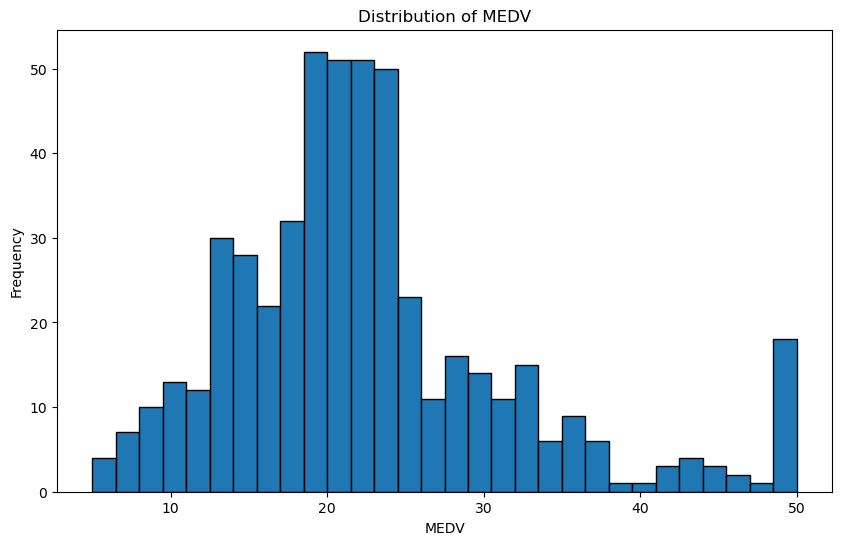

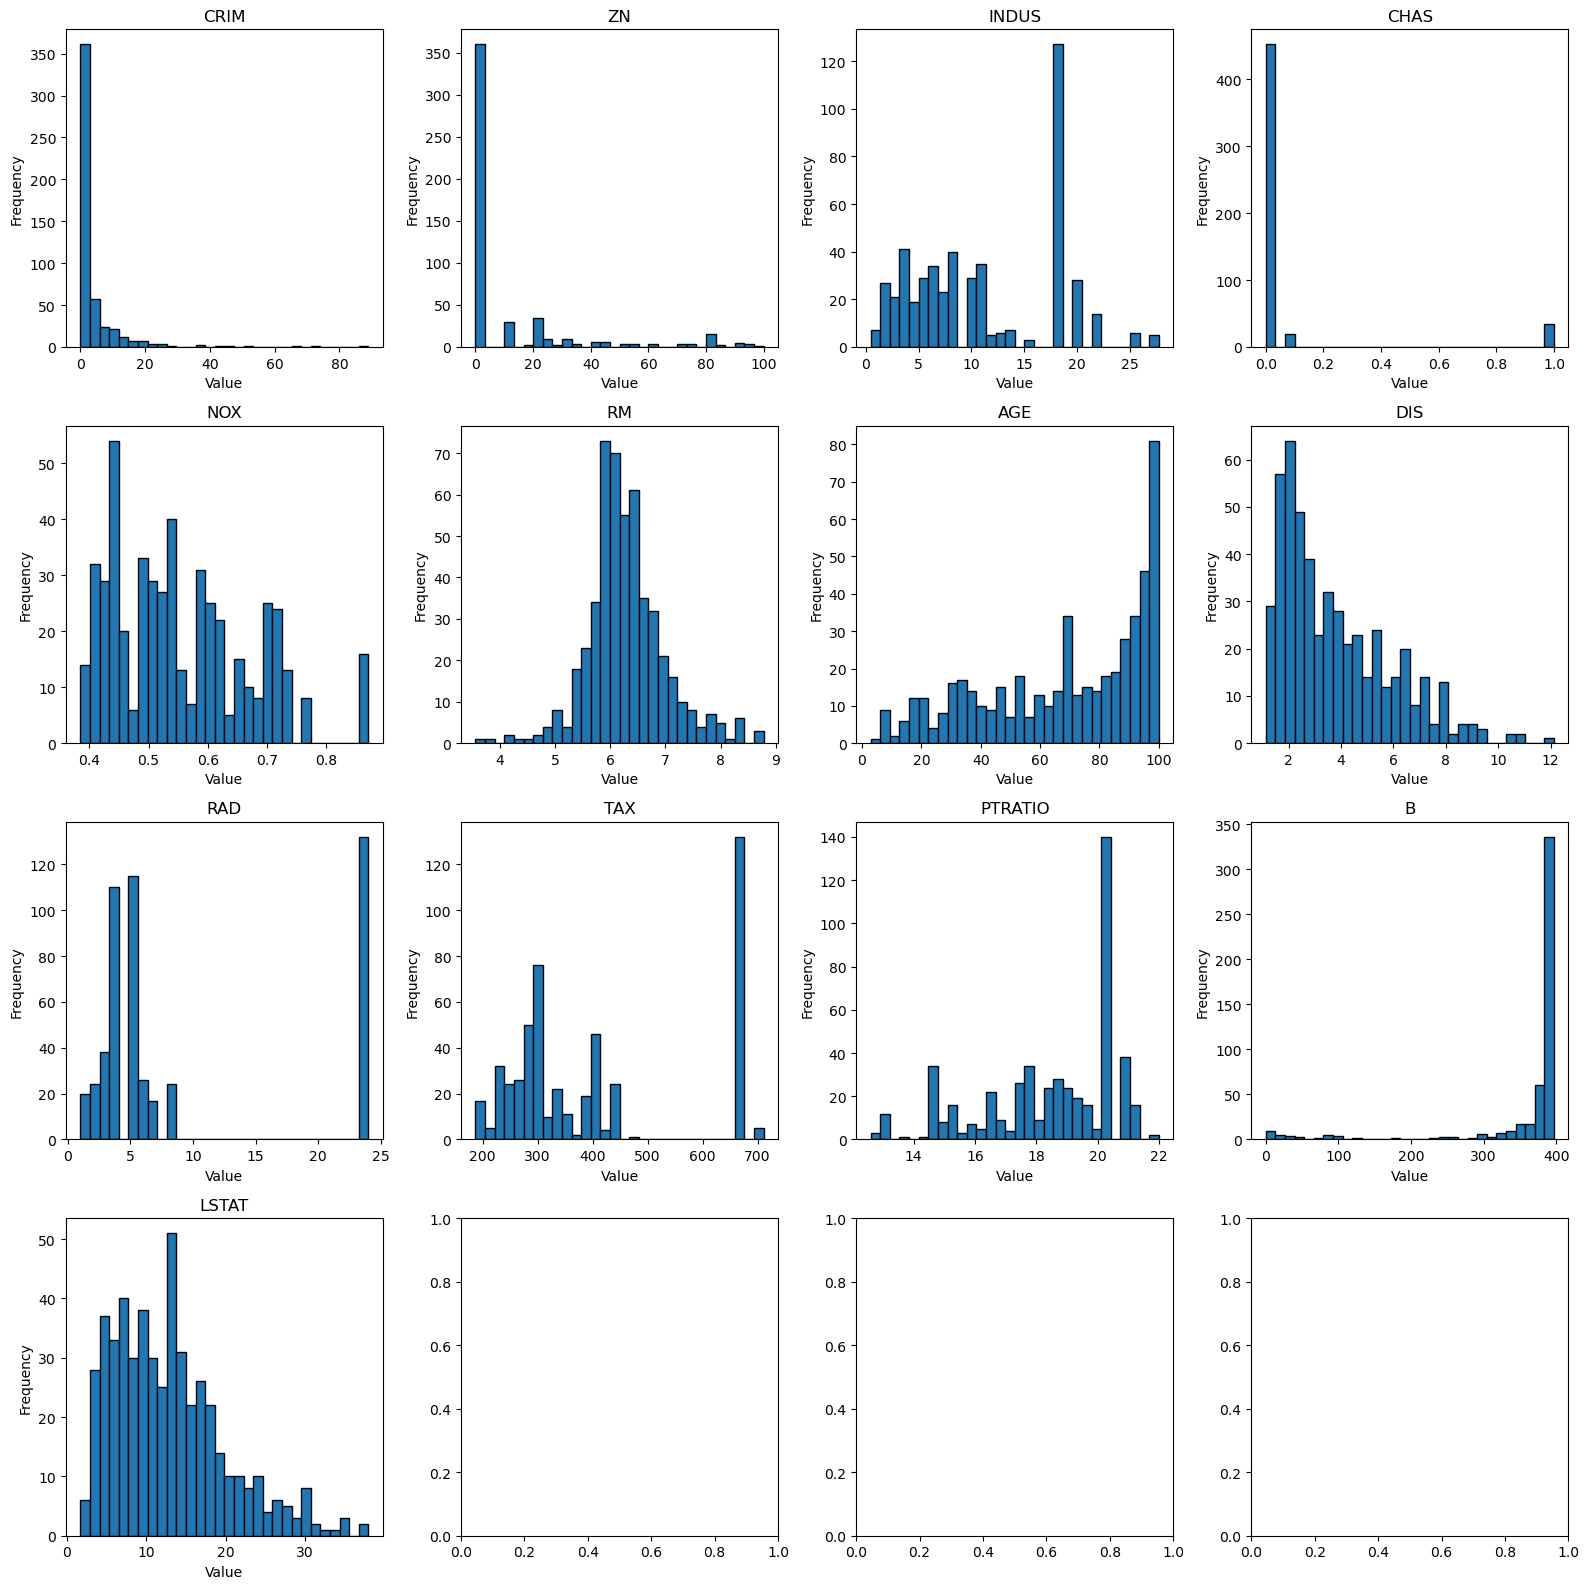

In [20]:
# Load the data
data = pd.read_csv('HousingData.csv')

# Handle missing values by filling with means
data.fillna(data.mean(), inplace=True)

# Split the data into features (X) and the target (y)
X = data.drop(columns=['MEDV'])
y = data['MEDV']

# Describe the dataset
dataset_description = data.describe()

# Print the mean, standard deviation, min, and max values for all attributes
print(dataset_description)

# Create a histogram to visualize the distribution of the target variable "MEDV"
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, edgecolor='k')
plt.title("Distribution of MEDV")
plt.xlabel("MEDV")
plt.ylabel("Frequency")
plt.show()


attributes = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)
for i, attribute in enumerate(attributes):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.hist(data[attribute], bins=30, edgecolor='k')
    ax.set_title(attribute)
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()


Mean Squared Error: 30.770434401142882
Root Mean Squared Error: 5.547110455105693
R-squared: 0.6128500118042253


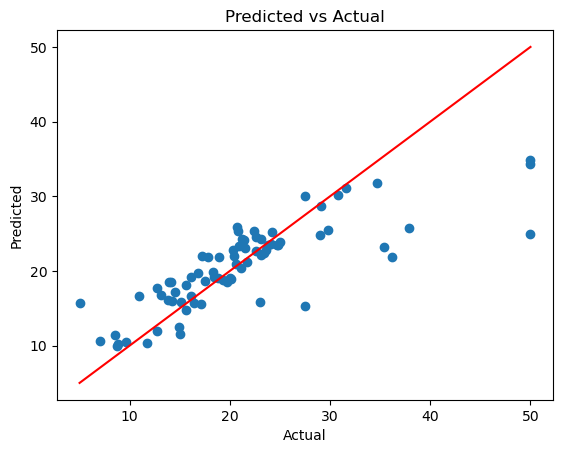

In [21]:
# Load the data
data = pd.read_csv('HousingData.csv')

# Handle missing values by filling with means
data.fillna(data.mean(), inplace=True)

# Split the data into features (X) and the target (y)
X = data.drop(columns=['MEDV'])
y = data['MEDV']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize and train the MLP regression model
mlp = MLPRegressor(input_size=X.shape[1], hidden_layers=[10, 15, 10], learning_rate=0.01, activation='tanh')             
mlp.trainminibatch(X_train, y_train.values.reshape(-1, 1), num_epochs=10000)

# Make predictions on the test set
y_pred = mlp.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

# plot predictions vs actual and also plot y = x line
x = np.linspace(np.min(y_test), np.max(y_test), 100)
y = x
plt.plot(x, y, color='red')
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()